In [8]:
from collections import Counter
import json 

import joblib
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline

%matplotlib notebook

# Load dataset and model
## dataset

In [2]:
file_path = [
    '../data/raw/uy_tweets_coronavirus_2020-04-09T09:19:19.598204.json',
#     '../data/raw/uy_tweets_covid19_2020-04-09T00:01:18.808683.json',
#     '../data/raw/uy_tweets_covid_19_2020-04-09T00:47:37.969046.json',
#     '../data/raw/uy_tweets_covid19uruguay_2020-04-08T20:45:11.934235.json',
#     '../data/raw/uy_tweets_covid_2020-04-09T02:48:43.809046.json',
#     '../data/raw/uy_tweets_quedateencasa_2020-04-09T01:48:09.328509.json',
]
tweets = []
for path in file_path:
    print(path)
    with open(path, 'r') as f:
        tweets.extend(json.load(f))

../data/raw/uy_tweets_coronavirus_2020-04-09T09:19:19.598204.json


In [5]:
cc = Counter([k['lang'] for k in tweets])
cc

Counter({'es': 58195,
         'en': 203,
         'und': 336,
         'ca': 268,
         'hu': 2,
         'pt': 42,
         'lt': 14,
         'cy': 2,
         'sv': 1,
         'fi': 1,
         'ro': 8,
         'fr': 14,
         'it': 8,
         'in': 1,
         'ru': 2,
         'de': 1})

In [6]:
dataset_uy = []
for tweet in tweets:
    keys_tw = ['created_at', 'id', 'full_text', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'lang']
    keys_usr = ['screen_name', 'location', 'followers_count', 'friends_count', 'listed_count', 'created_at', 'favourites_count', 'verified', 'statuses_count', ]
    tw = {key: tweet[key]for key in keys_tw}
    usr = {'user_' + key: tweet['user'][key]for key in keys_usr}
    tw = {**tw, **usr}
    dataset_uy.append(tw)

## Models

In [10]:
model_path = '../models/linear/log_multi_pipeline.joblib'
model = joblib.load(model_path)

# Make predictions

In [15]:
predictions = model.predict([k['full_text'] for k in dataset_uy])

Number of tweets for each class (negative, neutal, positive)

In [16]:
np.bincount(predictions+1)

array([17330, 38105,  3663])

## Testing tweets

In [17]:
idx = 1236
predictions[idx], dataset_uy[idx]['full_text']

(-1,
 '@TelenocheUy Cuanto ponen el Pit Cnt para el fondo del coronavirus ??\nAún no oí  ni lei nada ....')

In [18]:
idx = 59
predictions[idx], dataset_uy[idx]['full_text']

(0,
 'Casi 89.000 muertos en el mundo por el #coronavirus, según el recuento de la AFP del jueves 9 de abril a las 11 horas GMT #AFP https://t.co/f8r7bpjlxZ https://t.co/pc29W4YRLL')

In [19]:
idx = 1119
predictions[idx], dataset_uy[idx]['full_text']

(-1,
 'La crisis económica la van a pagar los trabajadores y el Estado. Nunca el capital. El Fondo Coronavirus se paga con deuda nacional, jubilaciones y salarios públicos. Nunca el capital.')

# Results

<IPython.core.display.Javascript object>


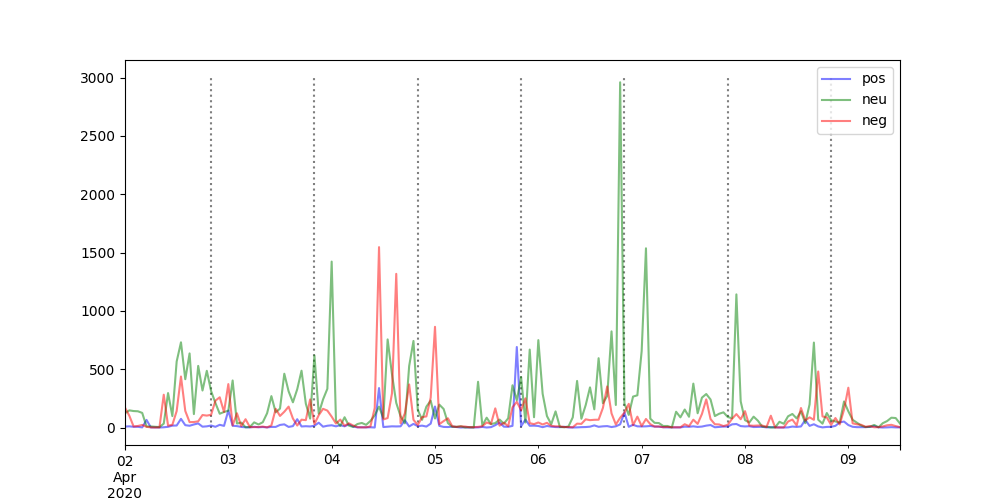

/home/cesar/software/houses-project/venv/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


In [20]:
df = pd.Series(predictions, index=pd.to_datetime([k['created_at'] for k in dataset_uy]), name='date')

df = df[df.index>'2020-04-02']

pos = df[df==1]
neu = df[df==0] + 1 
neg = df[df==-1] + 2 

rule = '1H'
f, ax = plt.subplots(figsize=(10,5))
pos.resample(rule).sum().plot(ax=ax, label='pos', color='b', alpha=0.5)
neu.resample(rule).sum().plot(ax=ax, label='neu', color='g', alpha=0.5)
neg.resample(rule).sum().plot(ax=ax, label='neg', color='r', alpha=0.5)
for k in range(2, 9):
    ax.vlines(f'2020-04-0{k} 20:00:00', 0, 3000, linestyle=':', alpha=0.5)
ax.legend()